# Analyze and classify images

In [1]:
# Created by Jesús García García - Master´s Degree in Big Data Analytics UEM

In [2]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC




# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Extracting the top 150 eigenfaces from 966 faces
done in 0.120s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s
Fitting the classifier to the training set
done in 22.817s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.047s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.62      0.57        13
     Colin Powell       0.75      0.87      0.81        60
  Donald Rumsfeld       0.72      0.78      0.75        27
    George W Bush       0.92      0.88      0.90       146
Gerhard Schroeder       0.74      0.80      0.77        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.93      0.78      0.85        36


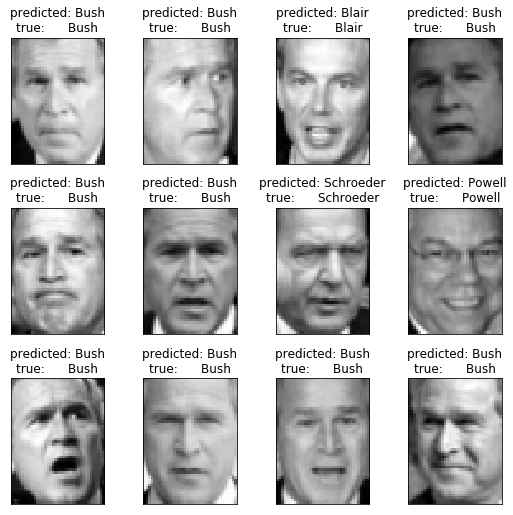

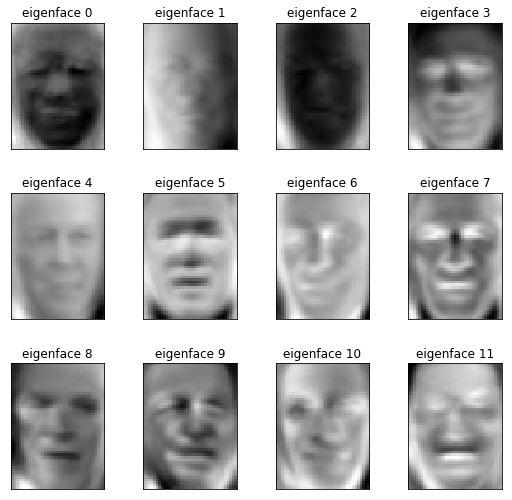

In [5]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
#Use MLP applying TensorFlow
import tensorflow as tf
import tensorflow.contrib.learn as learn

2018-04-19 22:41:01,374 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


In [8]:
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=1)]
classifier = learn.DNNClassifier(feature_columns=feature_columns, hidden_units=[10, 20, 10], n_classes=2)

2018-04-19 22:41:07,456 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\dnn.py:378: multi_class_head (from tensorflow.contrib.learn.python.learn.estimators.head) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
2018-04-19 22:41:07,478 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py:1165: BaseEstimator.__init__ (from tensorflow.contrib.learn.python.learn.estimators.estimator) is deprecated and will be removed in a future version.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
2018-04-19 22:41:07,507 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\estimator.py:427: RunConfig.__init__ (from tensorflow.contrib.learn.python.learn.estimators.run_config) is deprecated and will be removed in a future version.
Instructi

In [9]:
classifier.fit(X_train, y_train, steps=200, batch_size=20)

2018-04-19 22:41:12,857 From <ipython-input-9-6adc594028ea>:1: calling BaseEstimator.fit (from tensorflow.contrib.learn.python.learn.estimators.estimator) with x is deprecated and will be removed after 2016-12-01.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
2018-04-19 22:41:12,878 From <ipython-input-9-6adc594028ea>:1: calling BaseEstimator.fit (from tensorflow.contrib.learn.python.learn.estimators.estimator) with y is deprecated and will be removed after 2016-12-01.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x000001577A59E518>, 'hidden_units': [10, 20, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x00000157713AB488>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [10]:
note_predictions = classifier.predict(X_test)

2018-04-19 22:41:19,011 From C:\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py:497: calling DNNClassifier.predict (from tensorflow.contrib.learn.python.learn.estimators.dnn) with outputs=None is deprecated and will be removed after 2017-03-01.
Instructions for updating:
Please switch to predict_classes, or set `outputs` argument.
2018-04-19 22:41:19,144 From C:\Anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\dnn.py:463: calling BaseEstimator.predict (from tensorflow.contrib.learn.python.learn.estimators.estimator) with x is deprecated and will be removed after 2016-12-01.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
2018-04-19 22:41:19,289 Graph was finalized.
2018-04-19 22:41:19,290 

In [11]:
from sklearn.metrics import classification_report,confusion_matrix

In [12]:
print(confusion_matrix(y_test,note_predictions))

TypeError: Expected sequence or array-like, got <class 'generator'>

In [13]:
print(classification_report(y_test,note_predictions))

ValueError: Expected array-like (array or non-string sequence), got <generator object DNNClassifier.predict_classes.<locals>.<genexpr> at 0x000001577A7AA3B8>